In [1]:
import os
import pandas as pd
import numpy as np
import subprocess as sp
import glob
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from upsetplot import plot, UpSet
import gffutils

In [2]:
input_path = os.path.join("/data/akhtar/group2/rabbani/rna_project1904/pairwise_comparison") #deseq2 result
output_path = os.path.join("/data/akhtar/group2/rabbani/rna_project1904/pairwise_comparison/fdr0.05")

In [3]:
# the following cell needs to be run once, only if db is not generated

In [4]:
# Making a database from the gtf file
gtf_file = os.path.join("/data/repository/organisms/GRCm38_ensembl/gencode/m9/genes.gtf")
db = gffutils.create_db(gtf_file,
                        dbfn = os.path.join(output_path, "grcm38.db"),
                        disable_infer_transcripts=True,
                        disable_infer_genes=True)

In [5]:
# # all expressed genes within a time point
# for time in ['lps0', 'lps3', 'lps12']:
#     pattern = "ddr_"+time+"*"+time+"*tsv"
#     files = []
#     for file in glob.glob(os.path.join(output_path, pattern)):
#         name = os.path.basename(file)
#         first = name.split("_")[2]
#         if first != "shctrl":
#             continue
#         print(name)
#         df = pd.read_csv(file, sep = "\t", na_values = "NaN")
#         df = df.loc[df["up/down"].astype(str) != 'nan']
#         print(len(df))
#         files.append(df)
#     merged_df = files[0].merge(files[1], on = "gene_id", how = 'outer')
#     print(len(merged_df))
#     merged_df = merged_df["gene_id"]
#     merged_df.to_csv(os.path.join(output_path, "all_expressed_genes_in_"+time+".txt"),
#                      index = False, sep = "\t", header = None)


In [6]:
# per time point

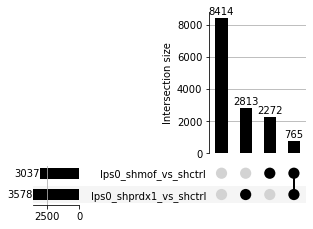

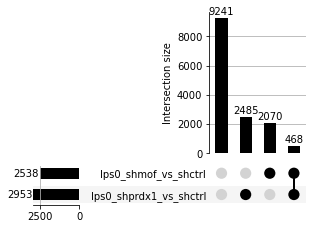

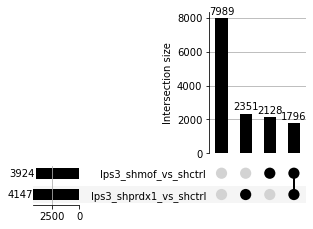

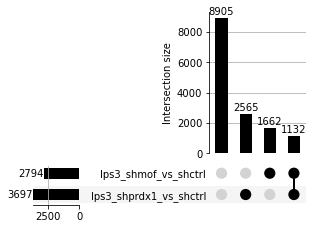

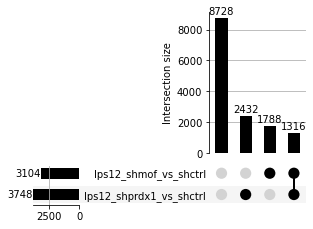

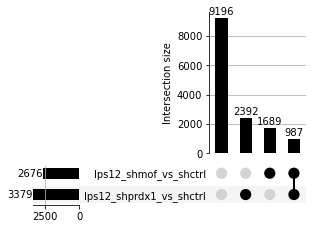

In [7]:
for time in ['lps0', 'lps3', 'lps12']:
    pattern = "ddr_"+time+"*"+time+"*tsv"
    dge_up = pd.DataFrame()
    dge_down = pd.DataFrame()
    all_diffs = pd.DataFrame()
    names = []
    i = 0
    for file in glob.glob(os.path.join(input_path, pattern)):
        name = os.path.basename(file).split(".tsv")[0]
        first = name.split("_")[2]
        if first == "shctrl":
            continue
        second = name.split("_")[4]
        name = "{}_{}_vs_{}".format(time, first, second)
        names.append(name)
        df = pd.read_csv(file, sep = "\t", usecols =["GeneID","Status"])
        df.rename(columns = {"Status": name}, inplace = True)
        df_up = df.copy()
        df_down = df.copy()
        # up
        df_up.loc[df_up[name] == "UP", name] = True
        df_up.loc[df_up[name] == "DOWN", name] = False
        df_up.loc[df_up[name] == "None", name] = np.nan
#         df_up = df_up.fillna(False)
        # down
        df_down.loc[df_down[name] == "UP", name] = False
        df_down.loc[df_down[name] == "DOWN", name] = True
        df_down.loc[df_down[name] == "None", name] = np.nan


#         df_down = df_down.fillna(False)
        if i == 0:
            dge_up = df_up.copy()
            dge_down = df_down.copy()
            all_diffs = df
        else:
            dge_up = dge_up.merge(df_up, on = "GeneID", how = 'outer')
            dge_down = dge_down.merge(df_down, on = "GeneID", how = 'outer')
            all_diffs = all_diffs.merge(df, on = "GeneID", how = 'outer')
            
        i = i + 1
        
    # save up and down df
    to_save_up = dge_up.copy()
    to_save_up.replace({True: "UP", False: "DOWN"}, inplace = True)
    to_save_up.dropna(how = 'any', inplace = True)
    to_save_up.to_csv(os.path.join(output_path,time+"_up_n_down.tsv"), sep = "\t", index = None, na_rep='NaN')
#   to_save_up.dropna(subset = to_save_up.columns[1:], how = 'all', inplace = True)
    
    all_diffs.to_csv(os.path.join(output_path,time+"_all_diffs.tsv"), sep = "\t", index = None, na_rep='NaN')

    dge_up.fillna(False, inplace= True)
    dge_up = dge_up.set_index(names)
    dge_down.fillna(False, inplace= True)
    dge_down = dge_down.set_index(names)
    plot(dge_up, subset_size='count' , show_counts='%d')
    current_figure = plt.gcf()
    current_figure.savefig(os.path.join(output_path,"UP_"+time+".png"))
    
    plot(dge_down, subset_size='count', show_counts='%d')
    current_figure = plt.gcf()
    current_figure.savefig(os.path.join(output_path,"DOWN_"+time+".png"))
    

In [8]:
db = gffutils.FeatureDB(os.path.join(output_path, "grcm38.db"))

In [9]:
# Add gene name
for time in ['lps0', 'lps3', 'lps12']:
    df = pd.read_csv(os.path.join(output_path,time+"_up_n_down.tsv"),
                     sep = "\t")
    names = []
    print(len(df))
    for index, row in df.iterrows():
        gene_id = row['GeneID']
        try:
            gene = db[gene_id]
            name = gene.attributes['gene_name']
            names.append(name[0])
        except:
            print("name not found!")
            names.append("no_name")
    df['gene_name'] = names
    df.to_csv(os.path.join(output_path,time+"_up_n_down.tsv"), sep = "\t", index = None)
    print(len(names))

3280
3280
4506
4506
3715
3715


In [10]:
# upset plot to show all genes which were differentially expressed in both condition of a time point 

/data/akhtar/group2/rabbani/rna_project1904/pairwise_comparison/fdr0.05/lps0_all_diffs.tsv
/data/akhtar/group2/rabbani/rna_project1904/pairwise_comparison/fdr0.05/lps3_all_diffs.tsv
/data/akhtar/group2/rabbani/rna_project1904/pairwise_comparison/fdr0.05/lps12_all_diffs.tsv


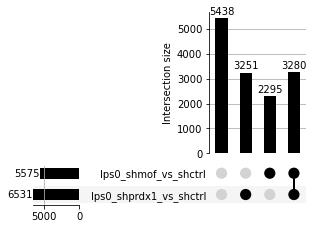

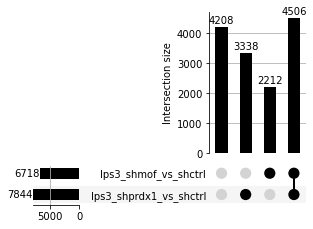

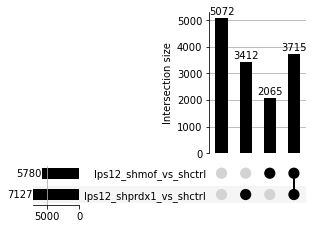

In [11]:
for time in ['lps0', 'lps3', 'lps12']:
    for file in glob.glob(os.path.join(output_path,time+"_all_diffs.tsv")):
        print(file)
        df = pd.read_csv(file, sep = "\t", na_values=np.nan)
        df.replace('UP', True, inplace= True)
        df.replace('DOWN', True, inplace= True)
        df.replace('None', np.nan, inplace= True)
        df.fillna(False, inplace = True)
        cols = [i for i in df.columns[1:]]
        df.set_index(cols, inplace=True)
        plot(df, subset_size='count' , show_counts='%d')
        current_figure = plt.gcf()
        current_figure.savefig(os.path.join(output_path,"all_diffs_"+time+".png"))

In [12]:
# for time in ['lps0', 'lps3', 'lps12']:
#     for file in glob.glob(os.path.join(output_path,time+"_all_diffs.tsv")):
#         df = pd.read_csv(file, sep = "\t", na_values=np.nan)
#         cols = [i for i in df.columns[1:]]
#         df.loc[(df[cols[0]] == "UP") & (df[cols[1]] == "UP"), [cols[0], cols[1]]] = True
#         df.loc[(df[cols[0]] == "DOWN") & (df[cols[1]] == "DOWN"), [cols[0], cols[1]]] = True
#         df.loc[(df[cols[0]] != True ) & (df[cols[1]] == "DOWN"), [cols[0], cols[1]]] = True
#         print(df)